In [54]:
import os
from imutils import paths
import pickle
import csv
import numpy as np
from numpy import genfromtxt

In [154]:
body_mapping_2d = ['center_hip', 'left_hip', 'left_knee', 'left_ankle', 'right_hip', 
                   'right_knee', 'right_ankle', 'mid_section', 'neck', 'nose', 'head', 
                   'right_shoulder', 'right_elbow', 'right_hand', 'left_shoulder', 
                   'left_elbow', 'left_hand']


In [55]:
for file_name in ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']:
    with open('/content/drive/MyDrive/driving_dataset/pickles/{}.pickle'.format(file_name), 'rb') as pf, open('/content/drive/MyDrive/driving_dataset/csvs/{}.csv'.format(file_name), 'w+') as cf:
        img_dict = pickle.load(pf)
        writer = csv.writer(cf)
        for img_name, custom_dict in img_dict.items():
            for _, keypoints in custom_dict.items():
                keypoints_lis = list(keypoints[0].flatten())
                keypoints_lis.append(int(file_name[-1]))
                writer.writerow(keypoints_lis)
            

In [153]:
all_data = []
for file_name in ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']:
    file_path = '/content/drive/MyDrive/driving_dataset/csvs/{}.csv'.format(file_name)
    data = genfromtxt(file_path, delimiter=',')[:2129, :]
    all_data.append(data)
    print(len(data))
combined_data = np.vstack(all_data)
print(combined_data.shape)

2129
2129
2129
2129
2129
2129
2129
2129
2129
2129
(21290, 35)


In [111]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils


In [112]:
class DistractedDriver(Dataset):
    def __init__(self, data_array):
        self.data = data_array
    
    def __getitem__(self, index):
        X = self.data[index, :-1]
        y = self.data[index, -1]
        return X, y

    def __len__(self):
        return self.data.shape[0] 

In [152]:
# dataset = DistractedDriver(combined_data)
batch_size = 128
validation_split = .2
shuffle_dataset = True
random_seed= 0
print(combined_data[5, :])

scaler = StandardScaler()
scaled_combined_data_x = scaler.fit_transform(combined_data[:, :-1])
print(scaled_combined_data_x)


X_train, X_val, y_train, y_val = train_test_split(scaled_combined_data_x[:, :-1], combined_data[:, -1], test_size=0.2, stratify=combined_data[:, -1])
print(X_train.shape, X_val.shape, y_train[np.newaxis].T.shape)
print(np.unique(combined_data[:, -1], return_counts=True))
train_xy = np.concatenate((X_train, y_train[np.newaxis].T), axis=1)
val_xy = np.concatenate((X_val, y_val[np.newaxis].T), axis=1)
train_dataset = DistractedDriver(train_xy)
val_dataset = DistractedDriver(val_xy)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
train_val_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
validation_loader = DataLoader(val_dataset, batch_size=len(val_dataset))




[269.23355  127.13766  259.04803  107.34657  234.4829   119.940895
 262.04376  115.74279  178.1628   161.32227  281.8157   203.90309
 208.12029  287.26556  359.7052   244.68474  368.0933   380.22372
 474.74194  215.8977   596.3694   386.221    391.46014  337.04315
 347.12305  386.221    528.0662   290.86395  509.49265  401.814
 620.3353   382.62262  600.5634   386.82077    0.      ]
[[-1.31911394e+00  3.67346667e-01 -1.33125832e+00 ...  4.47917880e-01
  -7.70167437e-01  4.52945424e-01]
 [-3.83750126e-01  4.63697822e-01 -4.17955176e-01 ...  8.24014946e-01
  -1.07102108e+00 -8.25453801e-01]
 [ 1.65745902e+00 -1.01337224e+00  1.79375922e+00 ... -7.37363043e-04
   1.10535065e+00 -1.98761126e-01]
 ...
 [-3.58239695e-01  2.50964613e-01 -3.93712931e-01 ...  1.13820592e+00
   1.00560973e+00  1.34358280e+00]
 [ 9.02132004e-01 -1.53391253e+00  7.88109511e-01 ... -6.69601925e-01
   1.14423789e+00 -6.92468128e-01]
 [ 8.22027179e-01  7.69321334e-01  1.04113043e+00 ...  6.17257131e-01
   8.23742072e

In [107]:
def check_accuracy(model, loader):   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for x, y in loader:
        with torch.no_grad():
            # x_var = Variable(x.type(gpu_dtype))
            x_var = x.float().to(device)

            scores = model(x_var)
            _, preds = scores.data.cpu().max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def train(model, loss_fn, optimizer, num_epochs = 1):
    total_train_loss = []
    total_val_loss = []
    total_train_acc = []
    total_val_acc = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        train_loss = []
        val_loss = []
        for t, (x, y) in enumerate(train_loader):
            x_var = x.float().to(device)
            y_var = y.long().to(device)

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            # train_loss.append(loss)
            # total_train_loss.append(loss)
            
            if (t + 1) % 100 == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.item()))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        for t, (x, y) in enumerate(validation_loader):
            with torch.no_grad():
                x_var = x.float().to(device)
                y_var = y.long().to(device)
                # print(x_var.shape)
                scores = model(x_var)
                
                
                loss = loss_fn(scores, y_var)
                val_loss.append(loss)
                total_val_loss.append(loss)
        train_acc =  check_accuracy(model, train_loader)
        total_train_acc.append(train_acc)
        for t, (x, y) in enumerate(train_val_loader):
            with torch.no_grad():
                x_var = x.float().to(device)
                y_var = y.long().to(device)

                scores = model(x_var)
                
                loss = loss_fn(scores, y_var)
                train_loss.append(loss)
                total_train_loss.append(loss)
        val_acc =  check_accuracy(model, validation_loader)
        total_val_acc.append(val_acc)

    return total_train_loss, total_val_loss, total_train_acc, total_val_acc
                

In [137]:
linear_model = nn.Sequential( 
    nn.Linear(33, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Linear(1024, 2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Linear(1024, 10)
).to('cuda')

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2, momentum=0.9) 

In [138]:
total_train_loss, total_val_loss, total_train_acc, total_val_acc = train(linear_model, loss_fn, optimizer, num_epochs=15)
check_accuracy(linear_model, train_loader)
check_accuracy(linear_model, validation_loader)

Starting epoch 1 / 15
tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0,
        2, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 1,
        2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 2, 0, 0, 0, 0, 1])
tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 0, 2, 0, 1, 0, 0, 1, 0, 0, 1,
        2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 0, 0,
        2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0])
tensor([2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 

0.1322378716744914

tensor(1.8750, device='cuda:0') tensor(1.8084, device='cuda:0')


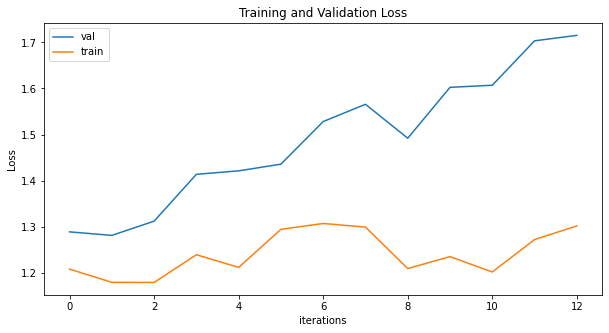

In [135]:
print(total_val_loss[0], total_train_loss[0])

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(total_val_loss[2:],label="val")
plt.plot(total_train_loss[2:],label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

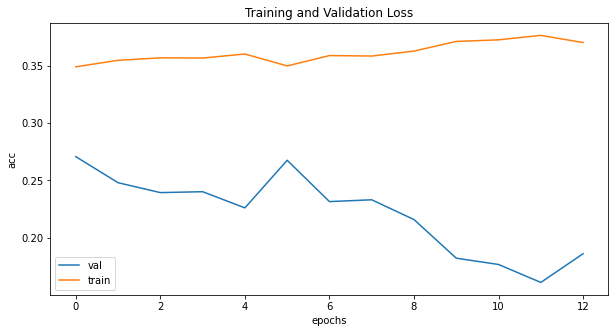

In [136]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(total_val_acc[2:],label="val")
plt.plot(total_train_acc[2:],label="train")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()